<a href="https://colab.research.google.com/github/stieve2/Assignment-5/blob/main/Final_Assignment_5_Bagging_and_Boosting_Stieve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 5: Bagging and Boosting
Sami Stieve

Import relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from io import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc

And introduce a function for printing a tree:

In [2]:
import pydot
from IPython.display import Image
def print_tree(estimator, features, class_names=None, filled=True):
  tree = estimator
  names = features
  color = filled
  classn = class_names
  dot_data = StringIO()
  export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
  graph = pydot.graph_from_dot_data(dot_data.getvalue())
  return(graph)

Get the data:

In [3]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 305 (delta 108), reused 123 (delta 76), pack-reused 117
Receiving objects: 100% (305/305), 26.30 MiB | 10.40 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Updating files: 100% (46/46), done.


In [4]:
wine = pd.read_csv('ML_656/winequality-red.csv', sep = ';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


And, in order to have a classification problem, let's call wines with scores above 6 high quality wines (true=1=positives) and below as low wuality wines (fale=0=negatives).

In [5]:
wine['quality'] = wine['quality'] > 6
wine['quality'].describe()

count      1599
unique        2
top       False
freq       1382
Name: quality, dtype: object

Let's set a seed so that our data is reproducible and let's split our data:

In [6]:
np.random.seed(42)
train, test = train_test_split(wine, test_size = 0.5)
test, val = train_test_split(test, test_size = 0.5)
X_train = train.drop(columns = ['quality']).values
y_train = train['quality'].values
X_val = val.drop(columns = ['quality']).values
y_val = val['quality'].values
X_test = test.drop(columns = ['quality']).values
y_test = test['quality'].values

Let's start our basic tree classifier, where we set the minimal cell size to 5 and a minimal node impurity decrease to 0.000001. If this value is higher, we don't get a very deep tree... Note that we are using a Classifier, which uses the gini in order to build the tree:

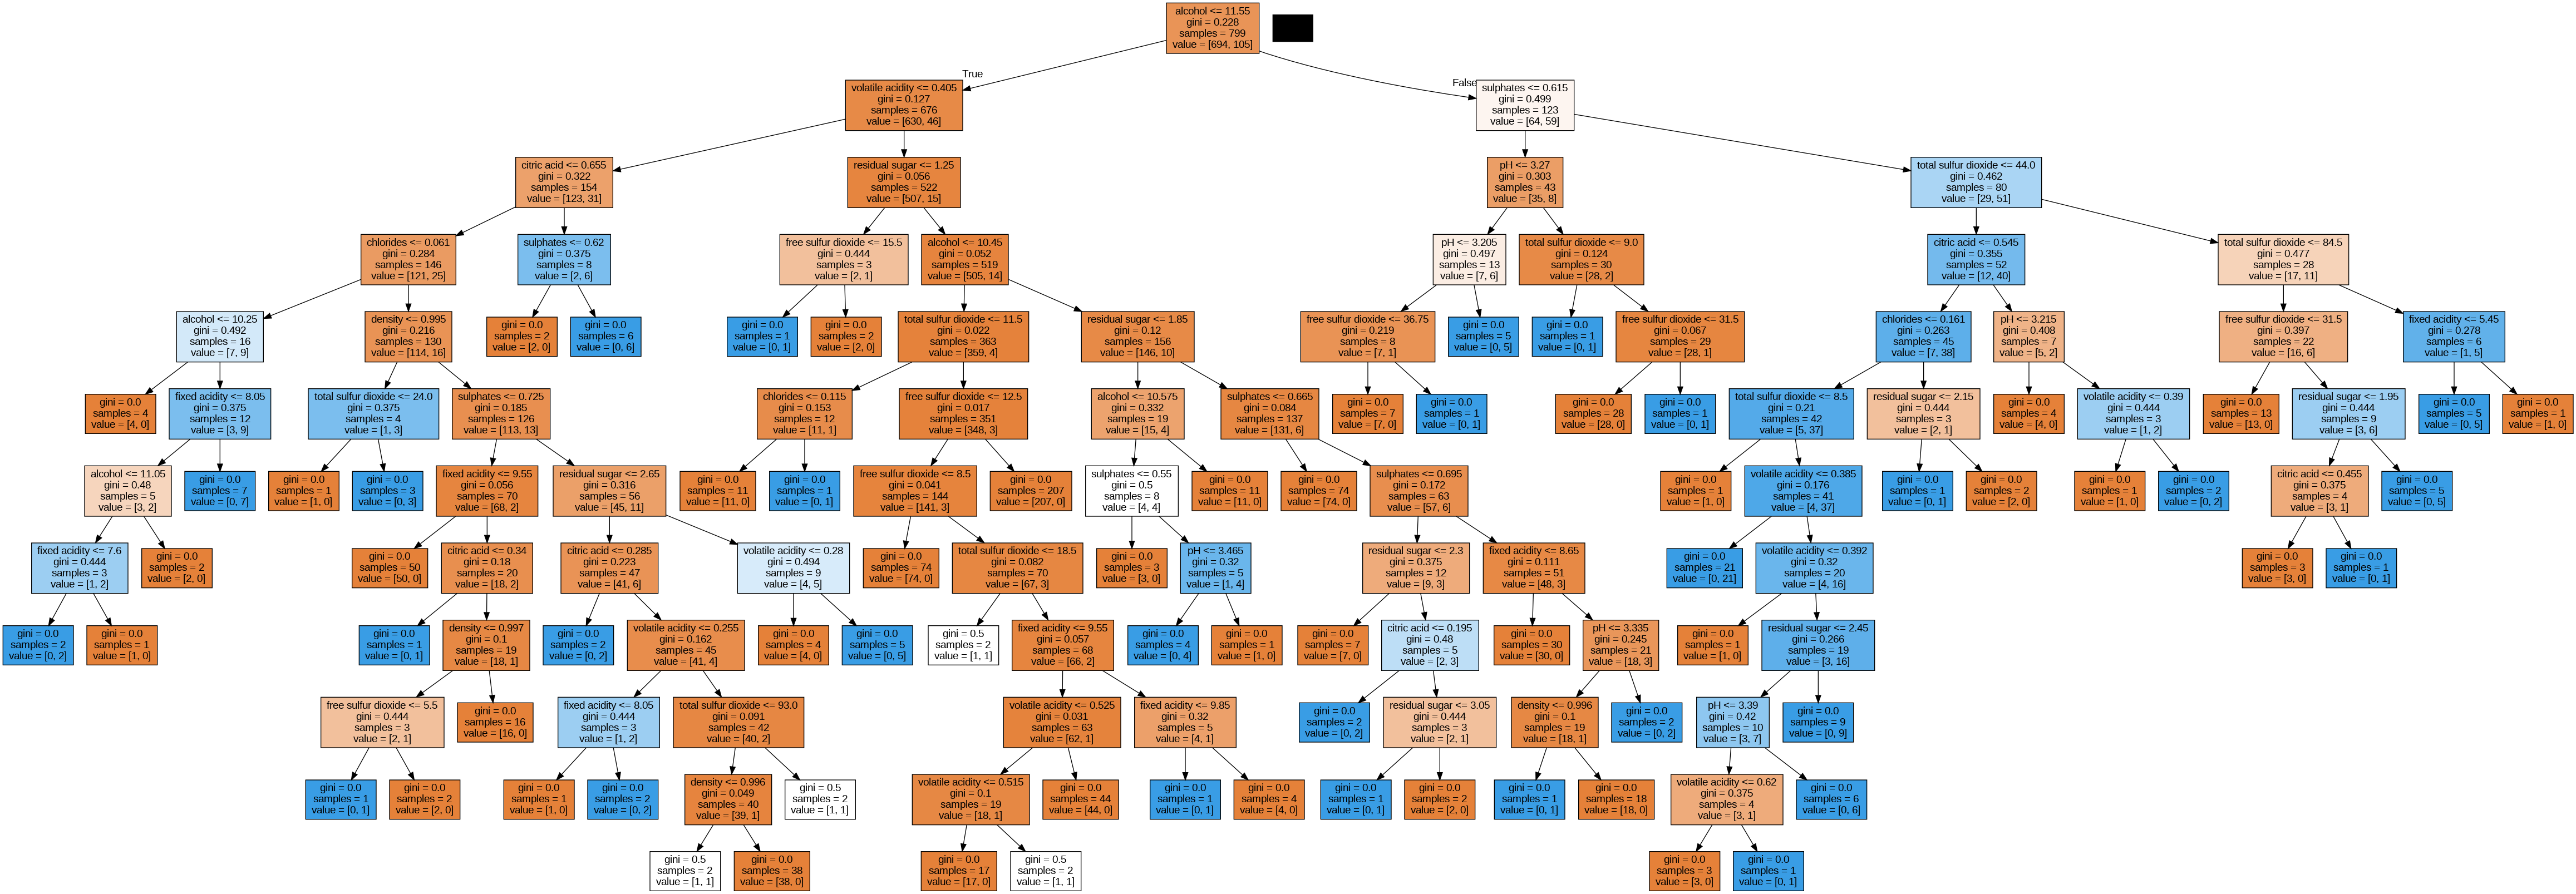

In [14]:
wine_tree = DecisionTreeClassifier(min_samples_split=3,min_impurity_decrease=0.000001)
wine_tree.fit(X_train, y_train)
graph, = print_tree(wine_tree, features= train.drop(columns = ['quality']).columns)
Image(graph.create_png())

And let's generate some predictions based on the test set:

In [15]:
wine_tree_preds = wine_tree.predict_proba(X_val)

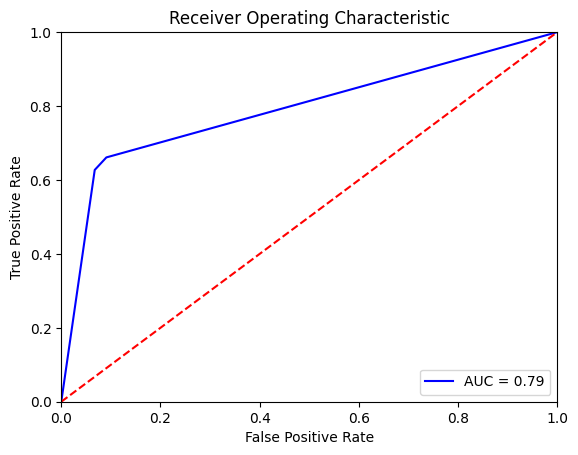

In [16]:
fpr, tpr, threshold = roc_curve(val['quality'], wine_tree_preds[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

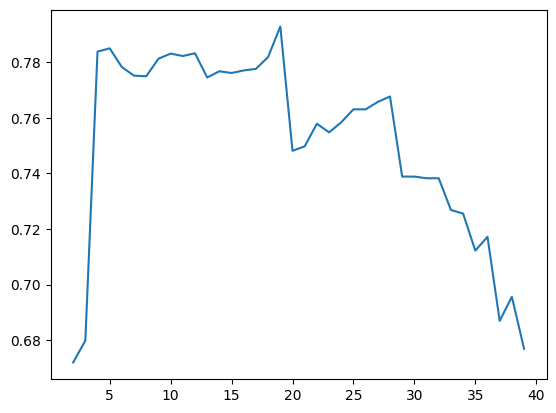

In [17]:
AUC_scores = []
scores = []
for i in range(2,40):
    wine_tree_try = DecisionTreeClassifier(min_samples_split=3,min_impurity_decrease=0.000001,max_leaf_nodes=i)
    wine_tree_try.fit(X_train, y_train)
    wine_tree_try_preds = wine_tree_try.predict_proba(X_val)
    fpr, tpr, threshold = roc_curve(val['quality'], wine_tree_try_preds[:,1])
    AUC_scores.append(auc(fpr, tpr))
plt.plot(range(2,40),AUC_scores)

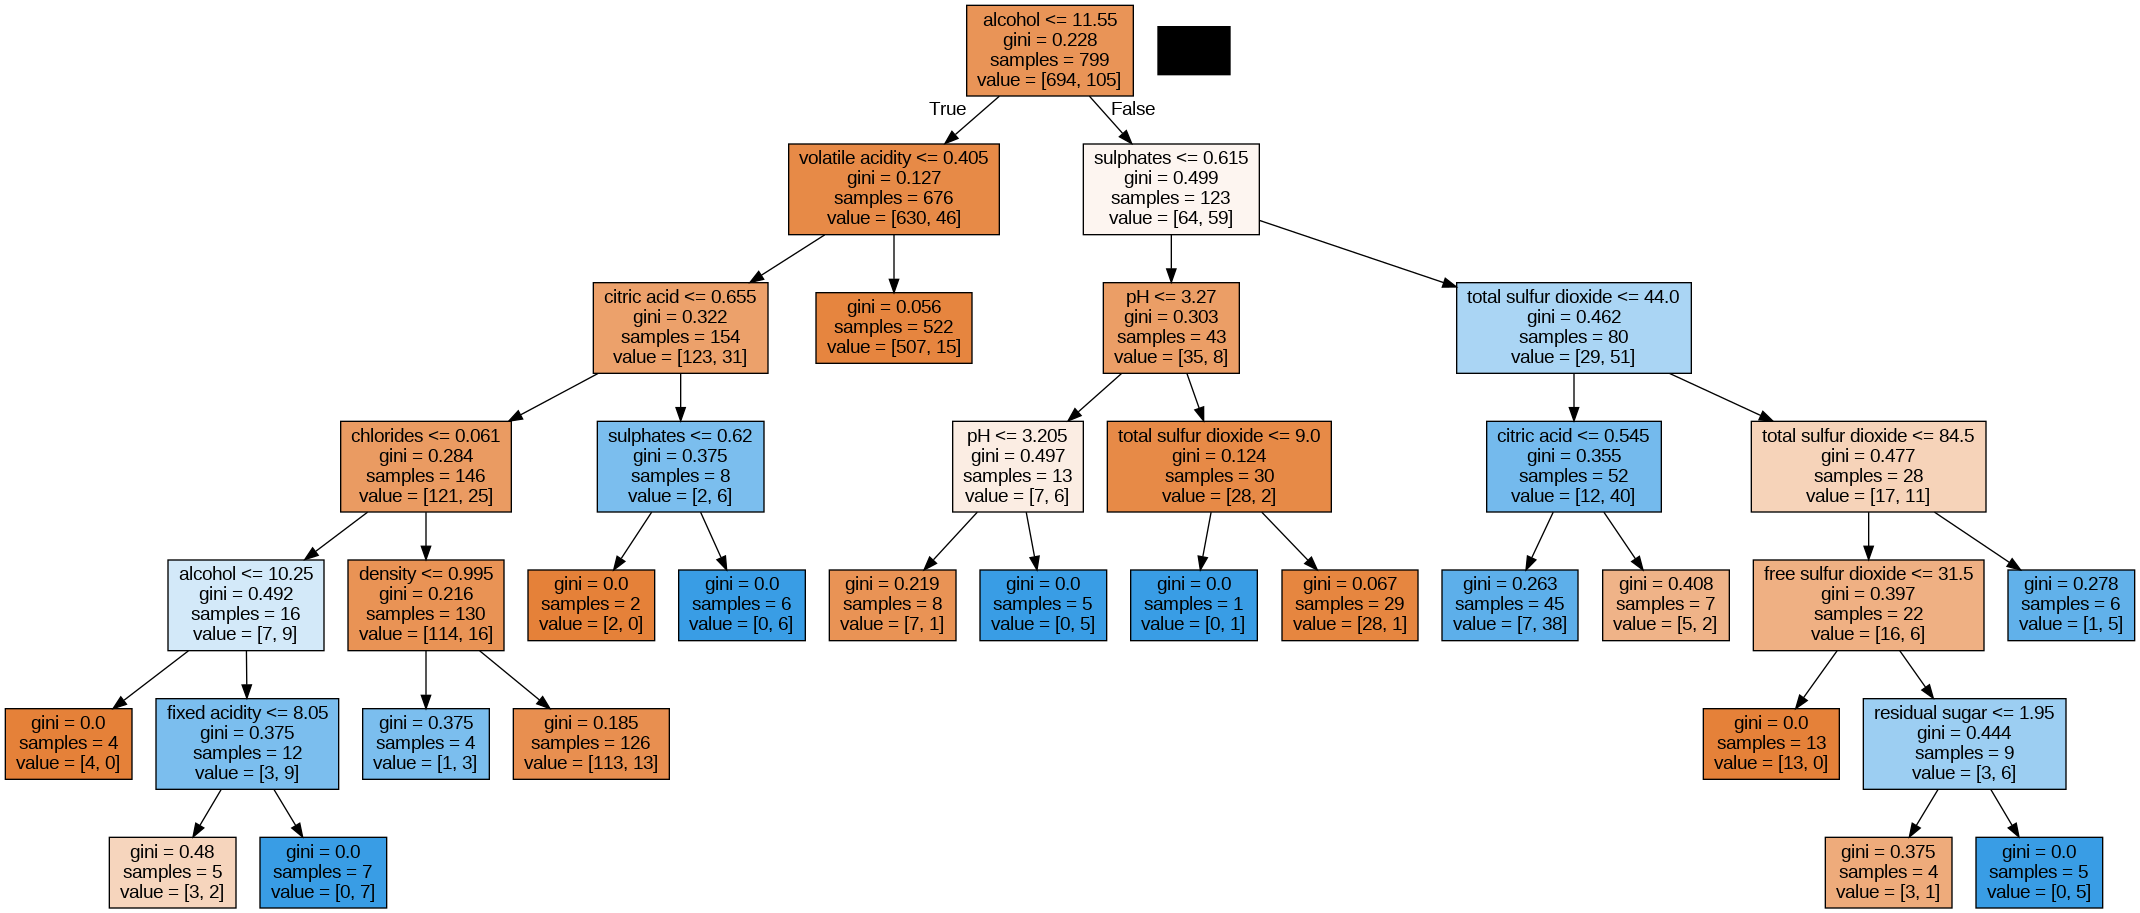

In [18]:
wine_tree_final = DecisionTreeClassifier(min_samples_split=3,min_impurity_decrease=0.000001,max_leaf_nodes=18)
wine_tree_final.fit(X_train, y_train)
graph, = print_tree(wine_tree_final, features= train.drop(columns = ['quality']).columns)
Image(graph.create_png())

In [21]:
wine_tree_final_preds = wine_tree_final.predict_proba(X_test)
wine_tree_final_preds_labels = wine_tree_final_preds[:,1] > 0.5

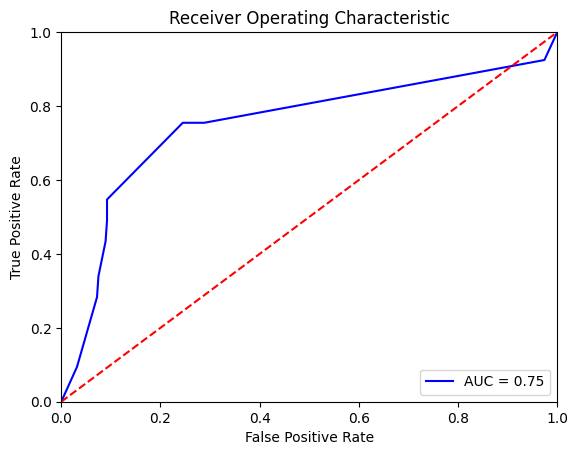

In [24]:
fpr, tpr, threshold = roc_curve(test['quality'], wine_tree_final_preds[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix for a 50% threshold for the test set

In [25]:
wine_tree_preds = wine_tree_final.predict_proba(X_test)
wine_tree_preds_labels = wine_tree_preds[:,1] > 0.5
table = pd.DataFrame({'Quality':test.quality,'Predicted':wine_tree_preds_labels})
table.groupby(['Quality','Predicted']).size().unstack('Quality')

Quality,False,True
Predicted,,
False,317,31
True,30,22


Run a Random Forest

In [26]:
rf = RandomForestRegressor(max_features=20, n_estimators=500, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=20, n_estimators=500, random_state=1)

ROC curve/AUC:

In [27]:
#Predictions
pred_rf = rf.predict(X_test)

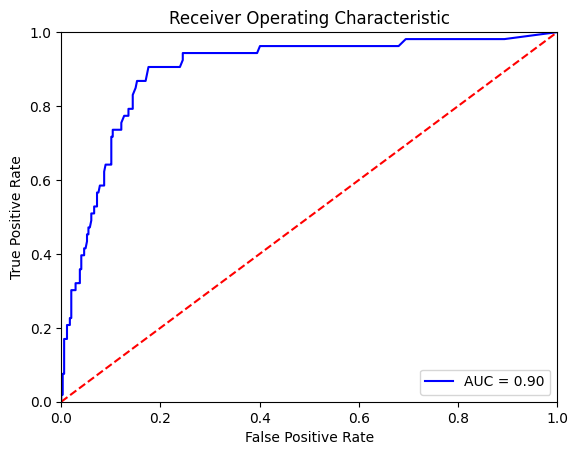

In [28]:
fpr, tpr, threshold = roc_curve(y_test, pred_rf)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
# The ROC curve has quite the improvement from the classification tree model.

Confusion Matrix for a 50% threshold for the test set (Random Forest)

In [30]:
wine_tree_preds = wine_tree_final.predict_proba(X_test)
wine_tree_preds_labels = pred_rf > 0.5
table = pd.DataFrame({'Quality':test.quality,'Predicted':wine_tree_preds_labels})
table.groupby(['Quality','Predicted']).size().unstack('Quality')

Quality,False,True
Predicted,,
False,329,30
True,18,23


Boosting Model

In [31]:
boost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01,random_state=1)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, random_state=1)

ROC Curve/AUC:

In [32]:
#Predictions
pred_boost = boost.predict(X_test)

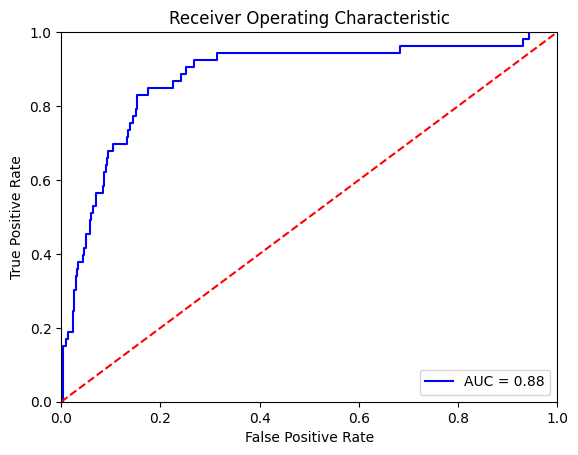

In [33]:
fpr, tpr, threshold = roc_curve(y_test, pred_boost)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix for a 50% threshold for the test set (Boosting Model)

In [34]:
wine_tree_preds = wine_tree_final.predict_proba(X_test)
wine_tree_preds_labels = pred_boost > 0.5
table = pd.DataFrame({'Quality':test.quality,'Predicted':wine_tree_preds_labels})
table.groupby(['Quality','Predicted']).size().unstack('Quality')

Quality,False,True
Predicted,,
False,329,29
True,18,24
